In [1]:
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
import math

(512, 512)


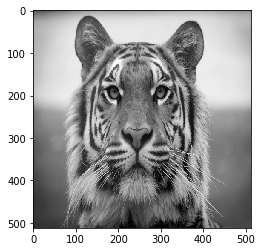

In [2]:
im = cv2.imread('08.png',0)
print(im.shape)
plt.imshow(im,cmap='gray')

# Décomposition en Ondelette

In [3]:
def histogram(array, mode='classique'):
    """Plot histogram avec normalisation par le nombre de pixel et définition de l'axe des abscisses"""
    if mode=='joli':    
        hist, bin_edges = np.histogram(array,bins=100,range=[-150,150])
    if mode == 'classique':
        hist, bin_edges = np.histogram(array,bins=100)

    plt.plot(bin_edges[1:],hist/array.size)
    plt.title(f"size of image : ({array.shape[1]},{array.shape[2]})")

## Les Paramètres

In [310]:
nb_level = 3
threshold = [1,27,30] # Seuil par échelle (=-1 si aucun)
bits_goal = [7,6,5] # nb bits par échelle
keep_level = [True,True,True] # liste des échelles que l'on conserve pour la reconstruction (1 si conserve 0 sinon)
keep_zeros_in_cr = False # Ne prend pas en compte les zéros dans le calcul du taux de compression

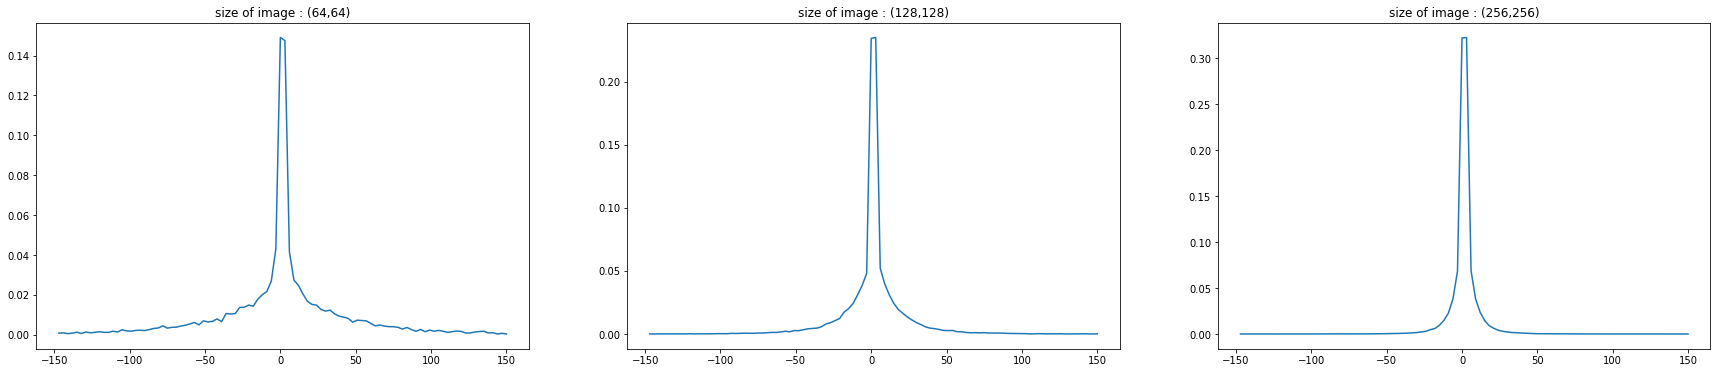

In [311]:
# compute the 2D DWT
c = pywt.wavedec2(im, 'db8',mode='periodization', level=nb_level)
arr, slices = pywt.coeffs_to_array(c)
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([c[level][0],c[level][1],c[level][2]]),'joli')

## Troncature ?

In [312]:
def filtering(array,threshold):
    return np.where((array < threshold) & (array > -threshold),0,array)

In [313]:
def troncature(array,thresholds=-1):
    if thresholds == -1:
        return array
    array_tronc = [array[0]]
    for level in range(1,nb_level+1):
        temp = []
        for detail in range(3):
            temp.append(filtering(array[level][detail],thresholds[level-1]))
        array_tronc.append(temp)
    return array_tronc

In [314]:
c_trcn = troncature(c,threshold)

## Quantification

In [315]:
def delta_bits(a,bits_goal,nb_level):
    """To generate the list of deltas in order to have the wanted number of bits in each level"""
    deltas = []
    for level in range(1,nb_level+1):
        temp = np.array([a[level][0],a[level][1],a[level][2]])
        val_max = 2**bits_goal[level-1]-1
        s = np.max(np.abs(temp))/val_max
        deltas.append(np.ceil(s))
    return deltas

In [316]:
def quantification(coeff,delta):
    quant = [coeff[0]]
    for level in range(1,nb_level+1):
        temp = []
        for detail in range(3):
            temp.append(np.fix(coeff[level][detail]/delta[level-1]))
        quant.append(temp)
    return quant 

In [317]:
# delta = [2**4,2**5,2**6]
delta = delta_bits(c_trcn,bits_goal,nb_level)
print(delta)
q = quantification(c_trcn,delta)

[5.0, 5.0, 6.0]


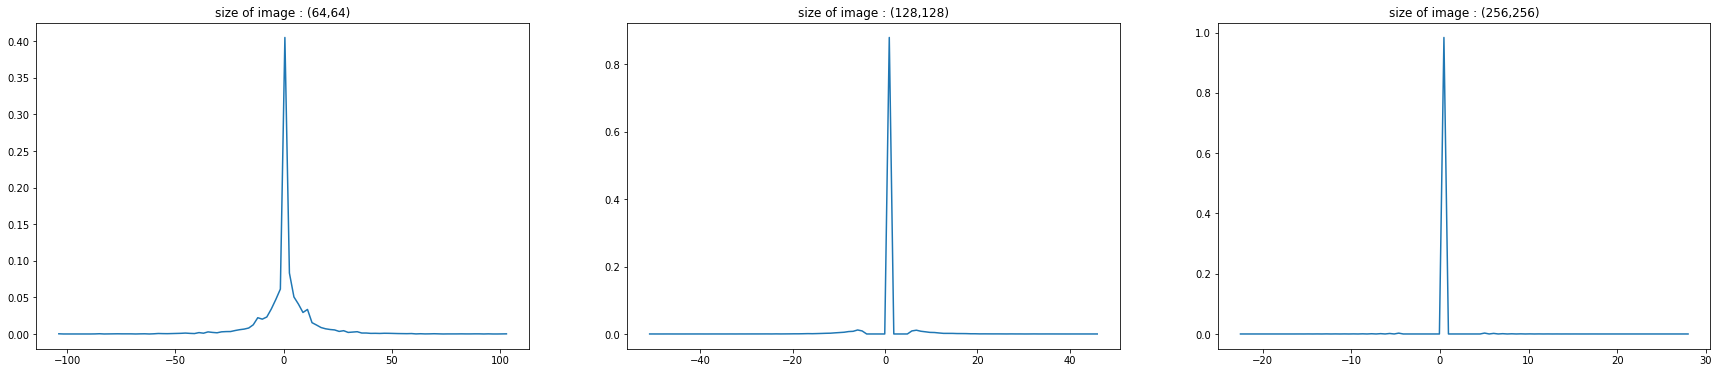

In [318]:
plt.figure(figsize=(30,6))
for level in range(1,nb_level+1):
    plt.subplot(1,nb_level,level)
    histogram(np.array([q[level][0],q[level][1],q[level][2]]))

In [319]:
def nb_bits(n):
    """pour connaitre le nombre de bits pour encoder n"""
    if n == 0:
        return 1
    n_bit = math.ceil(math.log2(n))
    if n_bit>0: return n_bit
    else : return 1

In [320]:
print(nb_bits(np.max(np.abs(q[0]))))
for level in range(1,nb_level+1):
    temp = np.array([q[level][0],q[level][1],q[level][2]])
    print(nb_bits(np.max(np.abs(temp))))

12
7
6
5


## Reconstruction

In [321]:
r=0.375
c_rec = [q[0]]
for level in range(1,nb_level+1):
    temp = []
    for detail in range(3):
        if keep_level[level-1]: # si on conserve cette échelle
            temp.append(q[level][detail]*(1+r*np.sign(q[level][detail]))*delta[level-1])
        else: # si on supprime l'échelle
            temp.append(np.zeros(q[level][detail].shape))
    c_rec.append(temp)

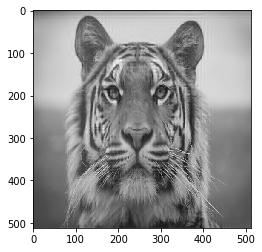

In [322]:
im_rec = pywt.waverec2(c_rec,'db8', mode='periodization')
plt.imshow(im_rec,cmap='gray')

## Mesure de l'erreur & Taux de compression

(-0.5, 511.5, 511.5, -0.5)

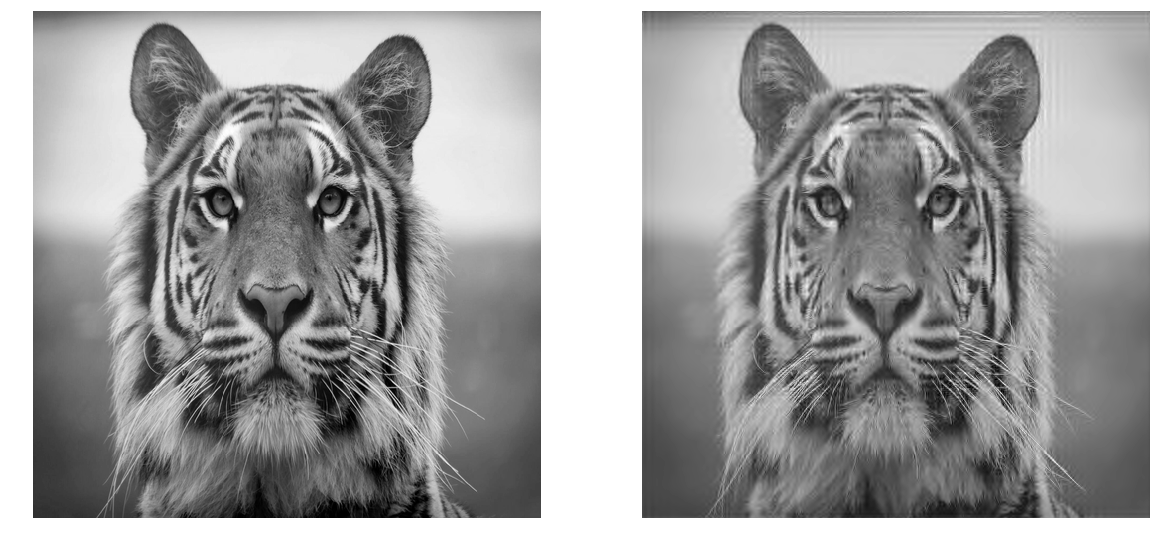

In [323]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(im_rec,cmap='gray')
plt.axis('off')

In [324]:
def RMSE_error(im,im_rec):
    return np.sqrt(np.mean((im-im_rec)**2))

In [325]:
def taux_comp(array_quant):
    p_ref = 8*im.size
    p_comp = array_quant[0].size*8 # Approx
    print(f"echelle {0} --> taux : {round(p_ref/p_comp)} | 0s : {np.sum(np.where(array_quant[0]==0,1,0))} | bits : {8}")
    
    for level in range(1,nb_level+1):
        temp = np.array([array_quant[level][0],array_quant[level][1],array_quant[level][2]])
        nb_bit_max = nb_bits(np.max(np.abs(temp)))
    
        if keep_level[level-1]:   # Si on conserve l'échelle
            if not keep_zeros_in_cr :
                p_comp += nb_bit_max * (temp.size- np.sum(np.where(temp==0,1,0)))
            else :
                p_comp += nb_bit_max * temp.size
            print(f"echelle {level} --> taux : {round(p_ref/p_comp)} | ratio_of_zeros : {round(np.sum(np.where(temp==0,1,0))/temp.size*100,1)} % | bits : {nb_bit_max}")
    
    return p_ref/p_comp

In [326]:
print(f"RMSE Error : {RMSE_error(im_rec,im)}")
print(f"Taux de compression : {taux_comp(q)}")

RMSE Error : 8.94579863876952
echelle 0 --> taux : 64 | 0s : 0 | bits : 8
echelle 1 --> taux : 24 | ratio_of_zeros : 35.9 % | bits : 7
echelle 2 --> taux : 17 | ratio_of_zeros : 87.9 % | bits : 6
echelle 3 --> taux : 15 | ratio_of_zeros : 98.4 % | bits : 5
Taux de compression : 15.047370309248763
